# CNN in Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
  def __init__(self,num_classes=10):
    super(SimpleCNN,self).__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2))

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2))

    self.conv_block3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2))

    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128*28*28,256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256,10)
    )

  def forward(self, x):
      x = self.conv_block1(x)
      x = self.conv_block2(x)
      x = self.conv_block3(x)
      x = self.fc(x)
      return x

## Loading Custom Image Dataset

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 207kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.86MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.5MB/s]


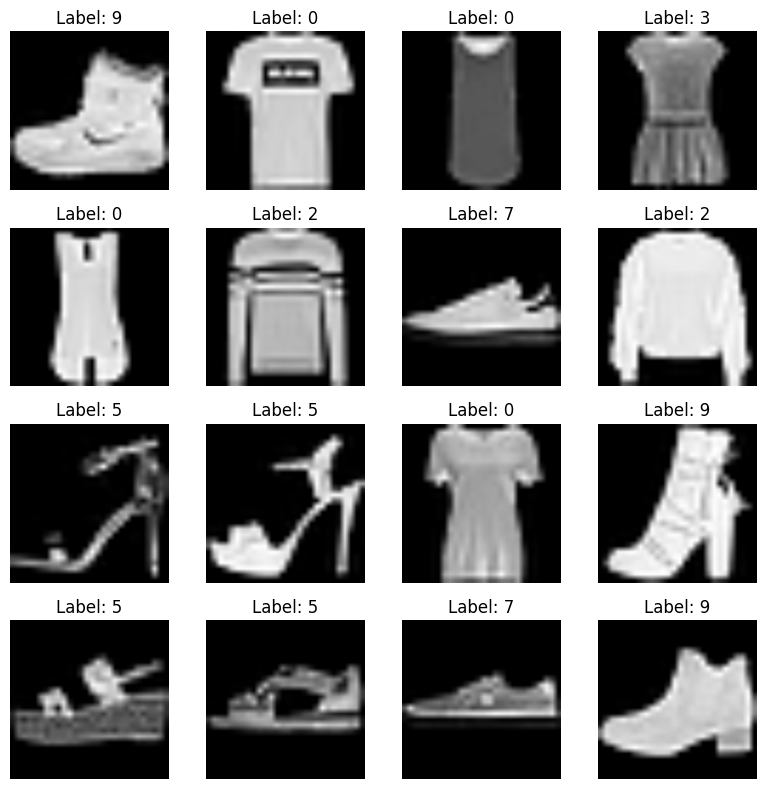

In [2]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)) # Repeats the grayscale image across 3 channels
])

# Load the dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Create a subplot with 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

# Loop through each subplot and plot an image
for i in range(4):
    for j in range(4):
        image, label = train_dataset[i * 4 + j]
        # Convert image tensor to numpy array and permute the dimensions
        image_numpy = image.numpy().transpose(1, 2, 0)
        axs[i, j].imshow(image_numpy, cmap='gray')
        axs[i, j].axis('off')  # Turn off axis
        axs[i, j].set_title(f"Label: {label}")

plt.tight_layout()
plt.show()  # Show plot

In [3]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Training Loop

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

import matplotlib.pyplot as plt

num_epochs = 10
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
f"Epoch {epoch+1}/{10}, Train Loss: {train_loss:.4f}"

Epoch 1/10, Train Loss: 0.4626, Train Acc: 0.8348, Val Loss: 0.3100, Val Acc: 0.8818
Epoch 2/10, Train Loss: 0.3064, Train Acc: 0.8873, Val Loss: 0.2800, Val Acc: 0.8969
Epoch 3/10, Train Loss: 0.2588, Train Acc: 0.9038, Val Loss: 0.2555, Val Acc: 0.9073
Epoch 4/10, Train Loss: 0.2220, Train Acc: 0.9186, Val Loss: 0.2453, Val Acc: 0.9131
Epoch 5/10, Train Loss: 0.1950, Train Acc: 0.9279, Val Loss: 0.2558, Val Acc: 0.9145
Epoch 6/10, Train Loss: 0.1651, Train Acc: 0.9383, Val Loss: 0.2920, Val Acc: 0.9096
Epoch 7/10, Train Loss: 0.1465, Train Acc: 0.9450, Val Loss: 0.2896, Val Acc: 0.9163
Epoch 8/10, Train Loss: 0.1290, Train Acc: 0.9517, Val Loss: 0.2717, Val Acc: 0.9173
Epoch 9/10, Train Loss: 0.1115, Train Acc: 0.9573, Val Loss: 0.3269, Val Acc: 0.9138
Epoch 10/10, Train Loss: 0.0973, Train Acc: 0.9632, Val Loss: 0.3481, Val Acc: 0.9187


'Epoch 10/10, Train Loss: 0.0973'

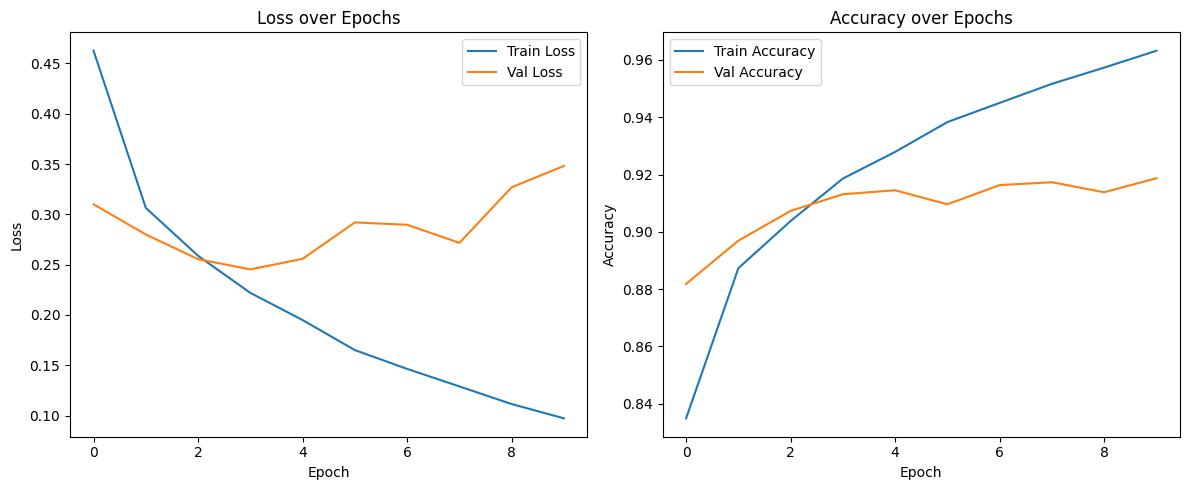

In [5]:
# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
